In [44]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

import torch
import torch.nn.functional as F

import pickle
import gzip

import src.models
from src.dataset import SimpleDataset
from src.preprocess import preprocess

from sklearn.model_selection import train_test_split

from captum.attr import Saliency, IntegratedGradients, DeepLiftShap, Lime, LayerGradCam, GuidedGradCam, InputXGradient, KernelShap, FeatureAblation, LayerAttribution, LRP, DeepLift
from captum.attr import visualization as viz

# sys.path.append("Pytorch-LRP/")
# from innvestigator import InnvestigateModel

# os.environ["CUDA_VISIBLE_DEVICES"] = "6"
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# HP

In [80]:
SEED=0
MODEL='resnet18_7'
DEVICE='cuda:6'
IDX=0

# Functions

In [81]:
def to_np(x):
    return x.detach().cpu().numpy()

### label informations
ds_beat_names = {
    0: 'undefined',     # Undefined
    1: 'normal',        # Normal
    2: 'pac',           # ESSV (PAC)
    3: 'aberrated',     # Aberrated
    4: 'pvc'            # ESV (PVC)
}

ds_rhythm_names = {
    0: 'undefined',     # Null/Undefined
    1: 'end',           # End (essentially noise)
    2: 'noise',         # Noise
    3: 'normal',        # NSR (normal sinusal rhythm)
    4: 'afib',          # AFib
    5: 'aflut'          # AFlutter
}

one_hot_to_true_label = {
    0: ds_beat_names[1],
    1: ds_beat_names[2],
    2: ds_beat_names[4]
}

def flatten_raw_label(raw_label):
    raw_label_dict = {}
    for i, idx in enumerate(raw_label):
        for j in idx:
            raw_label_dict[j] = ds_beat_names[i]
    return raw_label_dict
    
"""


y['btype'] = {
    1: 0,
    2: 1,
    4: 2
}[y['btype']]
"""

"\n\n\ny['btype'] = {\n    1: 0,\n    2: 1,\n    4: 2\n}[y['btype']]\n"

# Load Data

In [82]:
X, labels = pickle.load(gzip.GzipFile('dataset/12000_btype_new.pkl', 'rb'))
X = preprocess(X)
X_exp = np.expand_dims(X, [1, 2])    # shape: (12000, 1, 2049)
y = np.array([l['btype'] for l in labels]) # Extract btype label (beat label) 
y_btype_raw = np.array([l['btype_raw'] for l in labels])

X_train_ds, X_test_ds, y_train_ds, y_test_ds, y_train_btype_raw_ds, y_test_btype_raw_ds = train_test_split(
        X_exp, y, y_btype_raw, train_size=0.5, stratify=y, random_state=SEED
    )
print("X_test_ds[0]", X_test_ds[0]) ## checked whether this is same as when training
print("y_test_ds[0]", y_test_ds[0])

X_test_ds[0] [[[-0.06823771 -0.06823771 -0.28105217 ... -0.28105217 -0.28105217
   -0.49386668]]]
y_test_ds[0] 0


/tmp/ipykernel_52014/1091592423.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_btype_raw = np.array([l['btype_raw'] for l in labels])


In [83]:
print(X_test_ds.shape)
print(y_test_ds.shape)
print(y_test_btype_raw_ds.shape)

(6000, 1, 1, 2049)
(6000,)
(6000, 5)


# Load Model

In [84]:
# model = vars(src.models)[MODEL](in_channels=1, num_classes=3).to(DEVICE).eval()
model = torch.load("results/model_" + str(SEED) + ".pt", map_location=DEVICE).eval()

In [85]:
# for name, layer in model.named_modules():
#     if 'relu' in name:
#         layer.inplace=False
#         print(name)
#         print(layer)

In [86]:
X_test_ds.shape

(6000, 1, 1, 2049)

# Inference

In [87]:
input_tensor = torch.Tensor(X_test_ds[IDX]).to(DEVICE).unsqueeze(0)
yhat = model(input_tensor)
print(yhat)

softmax_yhat = F.softmax(yhat, dim=1)
prediction_score, pred_label_idx = torch.topk(softmax_yhat, 1)

pred_label_idx.squeeze_()
predicted_label = one_hot_to_true_label[pred_label_idx.item()]
print('True:', one_hot_to_true_label[y_test_ds[IDX]])
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

tensor([[ 3.5122, -0.2805, -1.4815]], device='cuda:6',
       grad_fn=<AddmmBackward0>)
True: normal
Predicted: normal ( 0.9715202450752258 )


In [88]:
## Attribution models
saliency = Saliency(model)
ig = IntegratedGradients(model)
inputgrad = InputXGradient(model)

lrp = LRP(model)

lime = Lime(model)
ks = KernelShap(model)
dl = DeepLift(model)
dls = DeepLiftShap(model)

ggcam = GuidedGradCam(model, model.layer4)
gcam = LayerGradCam(model, model.layer4)

ablator = FeatureAblation(model)

## Attribution results
saliency_x = saliency.attribute(input_tensor, target=pred_label_idx)
ig_x = ig.attribute(input_tensor, target=pred_label_idx)
inputgrad_x = inputgrad.attribute(input_tensor, target=pred_label_idx)

lrp_x = lrp.attribute(input_tensor, target=pred_label_idx)

lime_x = lime.attribute(input_tensor, target=pred_label_idx, n_samples=200)
ks_x = ks.attribute(input_tensor, target=pred_label_idx, n_samples=200)

dl_x = dl.attribute(input_tensor, target=pred_label_idx)
# dls_x = dls.attribute(input_tensor, target=pred_label_idx, baselines=torch.Tensor(X_train_ds[:100]).to(DEVICE))
dls_x = dls.attribute(input_tensor, target=pred_label_idx, baselines=torch.randn(X_train_ds[:100].shape).to(DEVICE))
ggcam_x = ggcam.attribute(input_tensor, target=pred_label_idx)
gcam_x = gcam.attribute(input_tensor, target=pred_label_idx)


# feature_mask = torch.cat((torch.arange(X_test_ds[IDX].shape[1] // 250).repeat_interleave(250), torch.Tensor([X_test_ds[IDX].shape[1] // 250 - 1]*(X_test_ds[IDX].shape[1] % 250))), 0).unsqueeze(0)
fabl_x = ablator.attribute(input_tensor, target=pred_label_idx)

us_gcam_x = LayerAttribution.interpolate(gcam_x, (1, input_tensor.shape[-1]))

attr_dict = {'Saliency': saliency_x, 'InputXGrad': inputgrad_x, 'Integrated Gradient':ig_x, 'LIME': lime_x, 'KernelShap': ks_x, 'Deep Lift':dl_x, 'Deep Lift SHAP':dlf_x, 'Feature Ablation': fabl_x, 'LRP': lrp_x, 'GradCAM': us_gcam_x, 'GuidedGCAM': ggcam_x}

/home/xlpczv/anaconda3/envs/ecg/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/xlpczv/anaconda3/envs/ecg/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/xlpczv/anaconda3/envs/ecg/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/home/xlpczv/anaconda3/envs/ecg/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


<Figure size 2000x500 with 0 Axes>

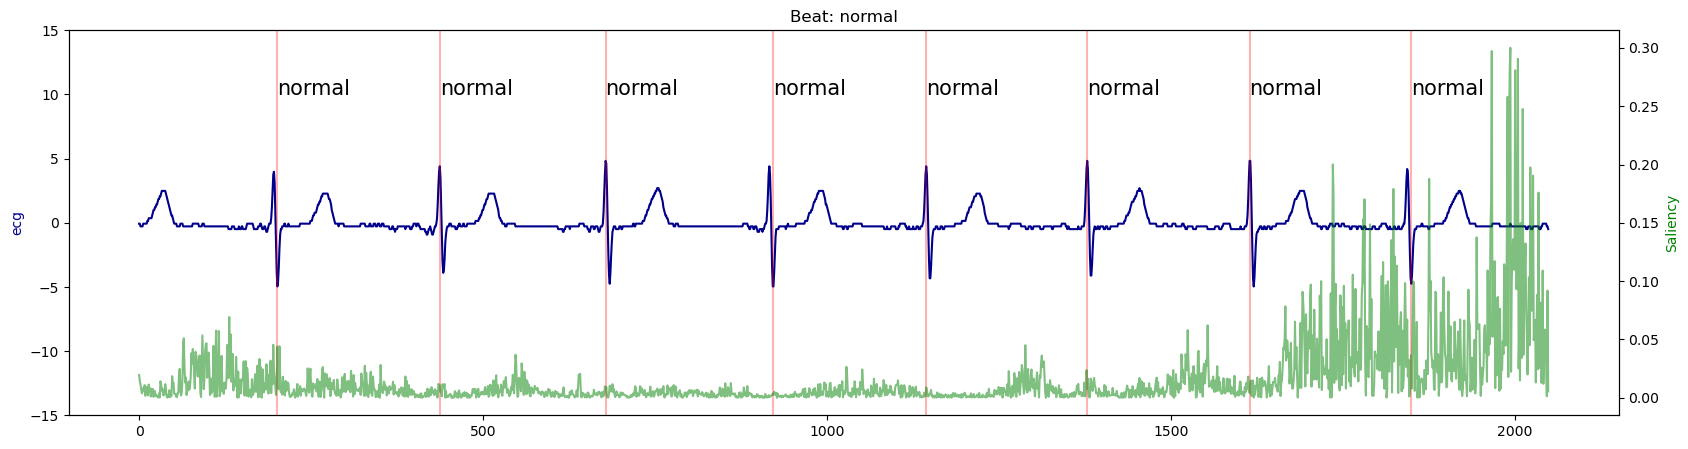

<Figure size 2000x500 with 0 Axes>

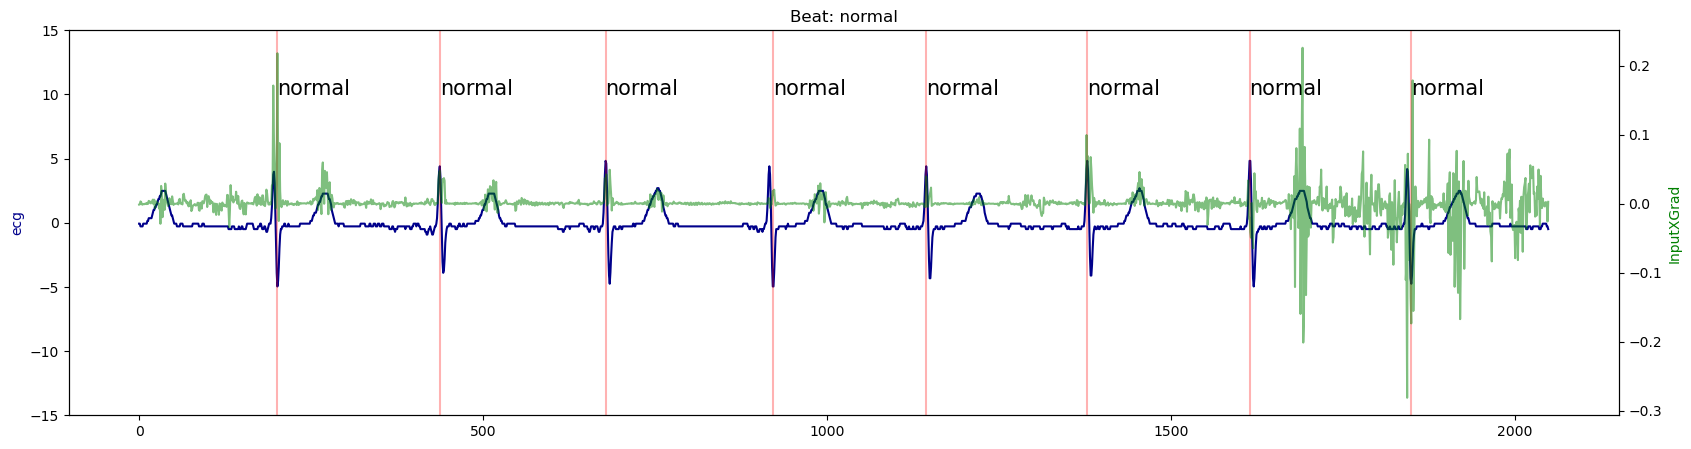

<Figure size 2000x500 with 0 Axes>

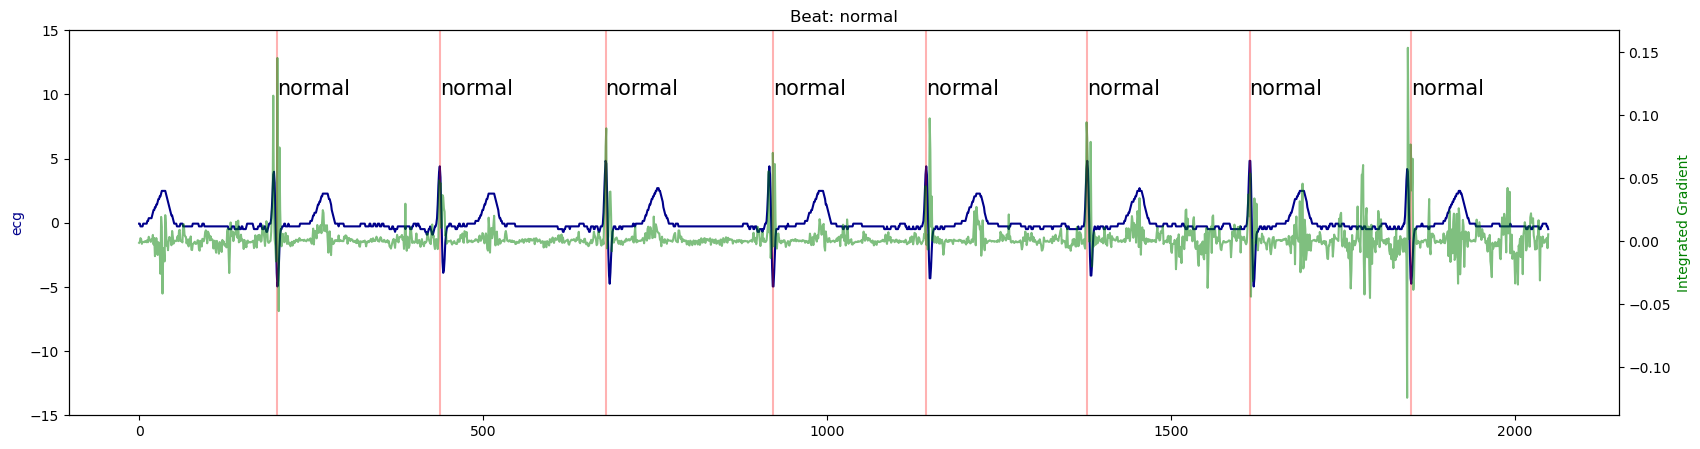

<Figure size 2000x500 with 0 Axes>

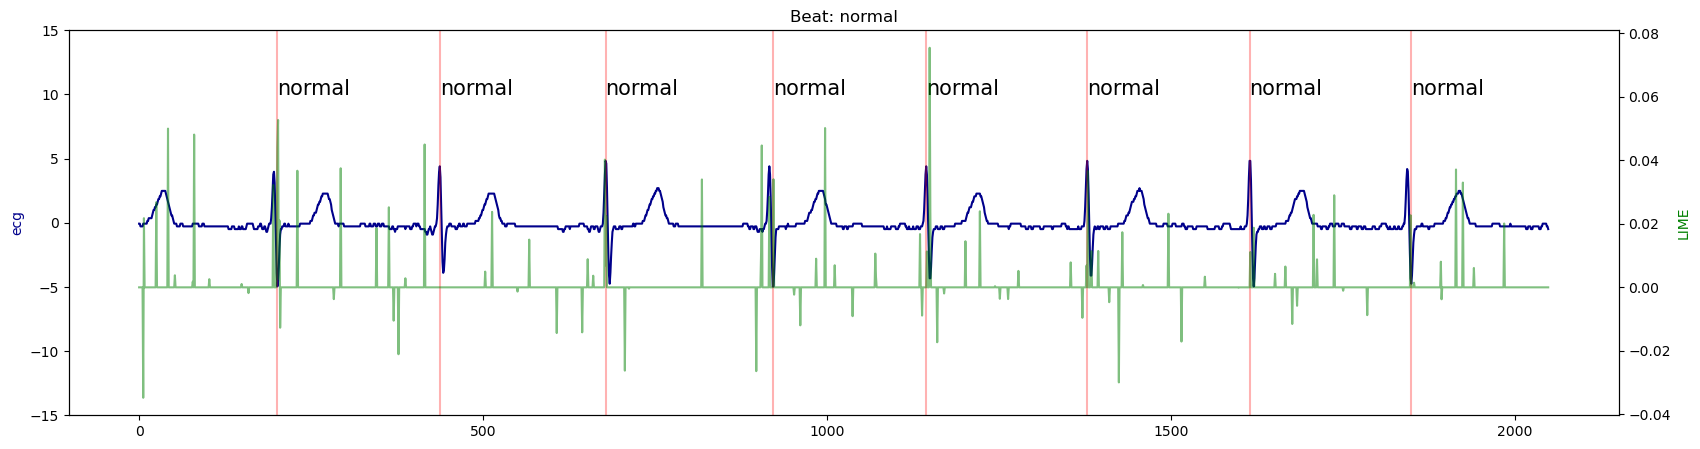

<Figure size 2000x500 with 0 Axes>

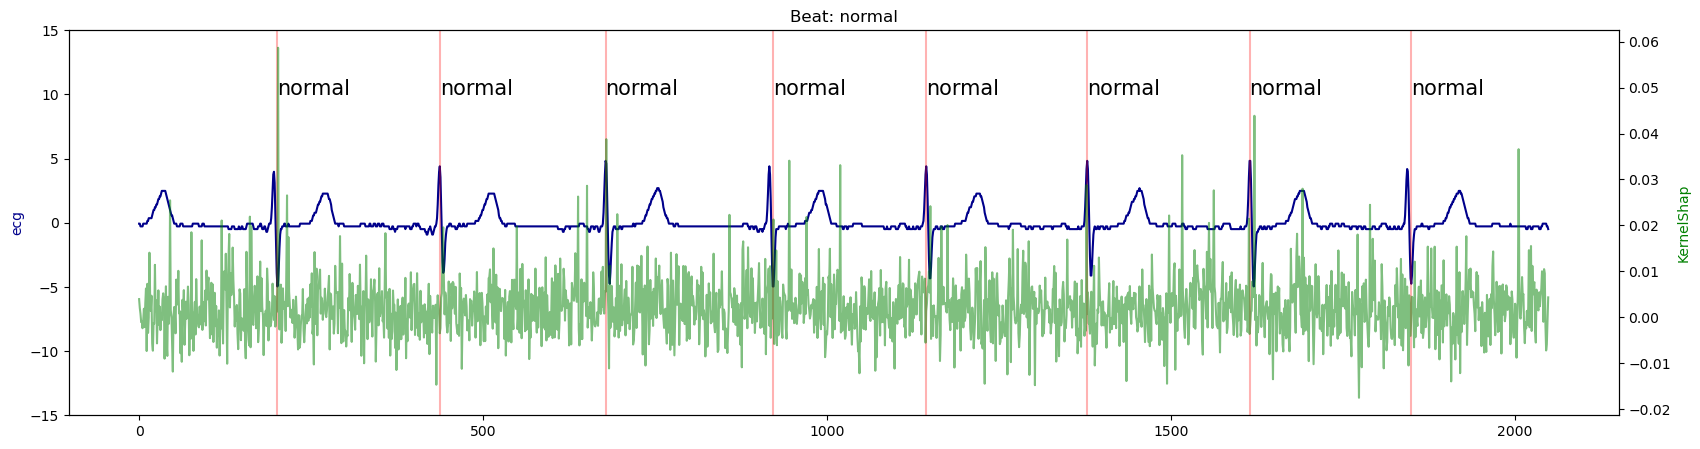

<Figure size 2000x500 with 0 Axes>

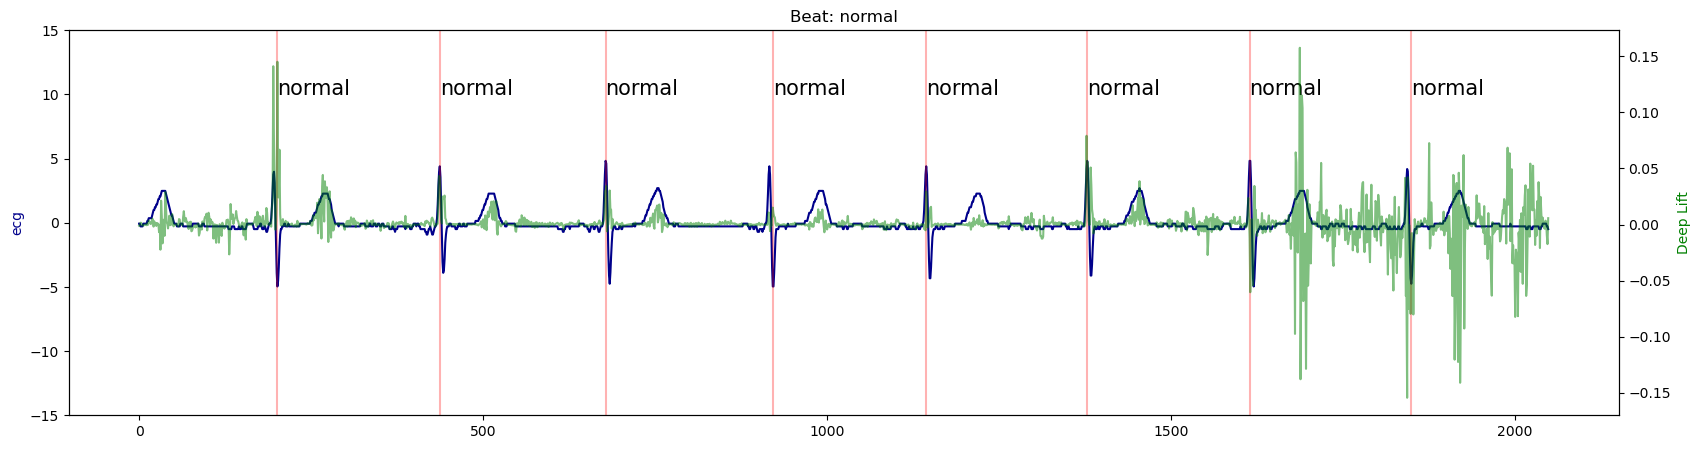

<Figure size 2000x500 with 0 Axes>

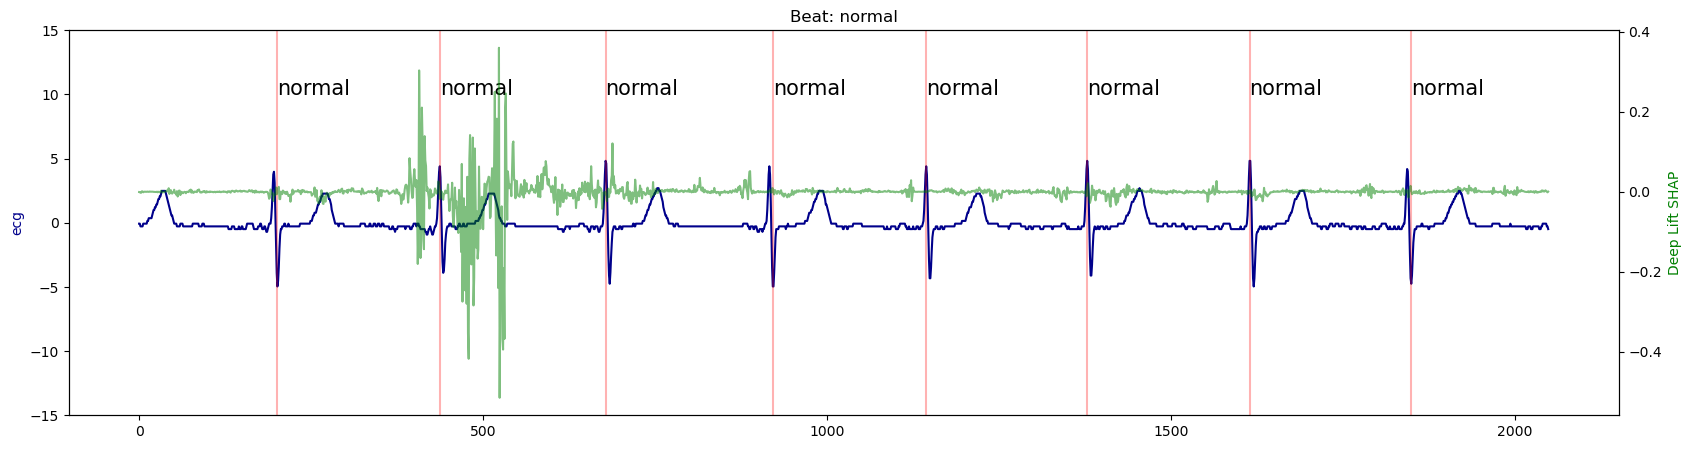

<Figure size 2000x500 with 0 Axes>

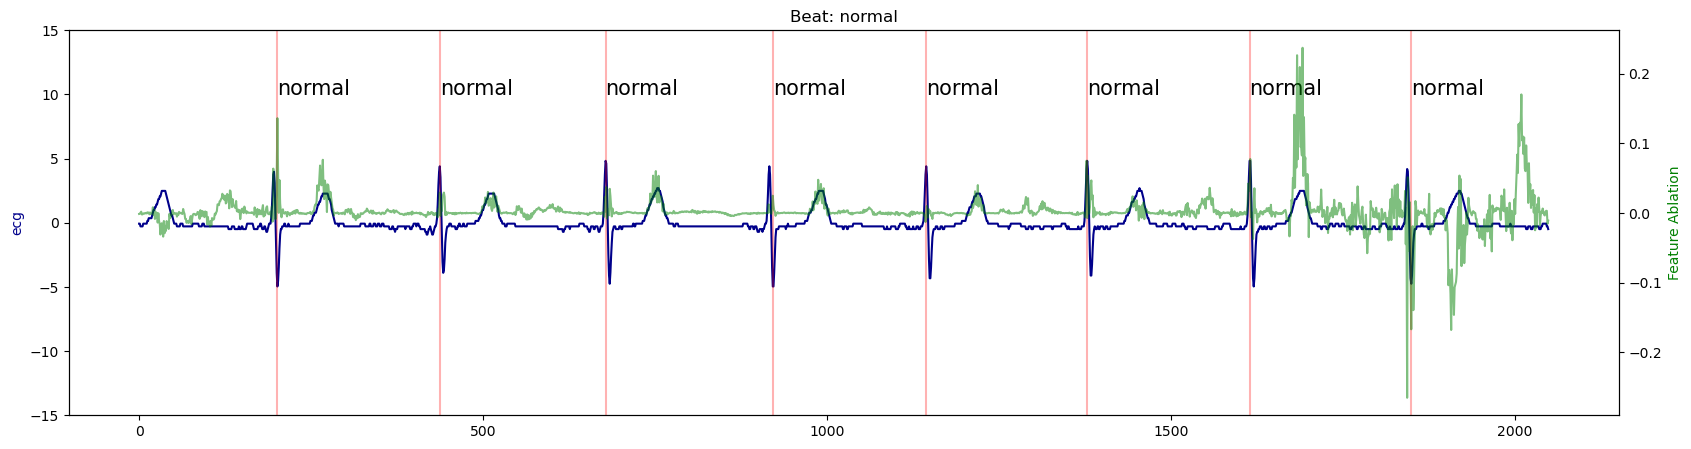

<Figure size 2000x500 with 0 Axes>

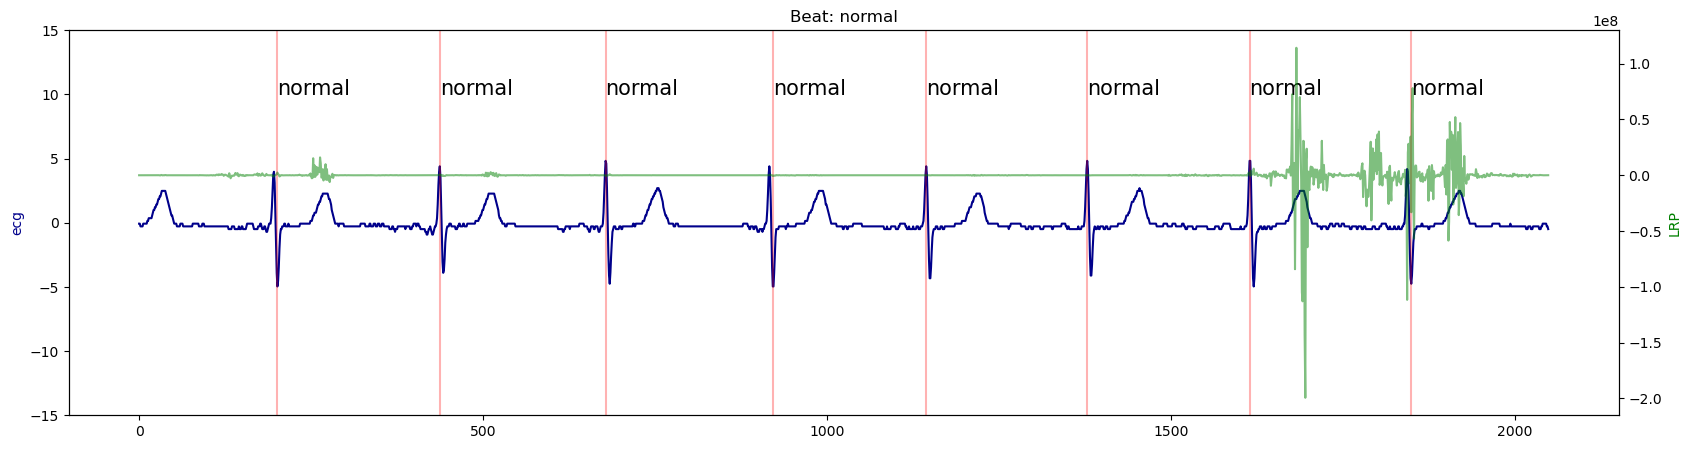

<Figure size 2000x500 with 0 Axes>

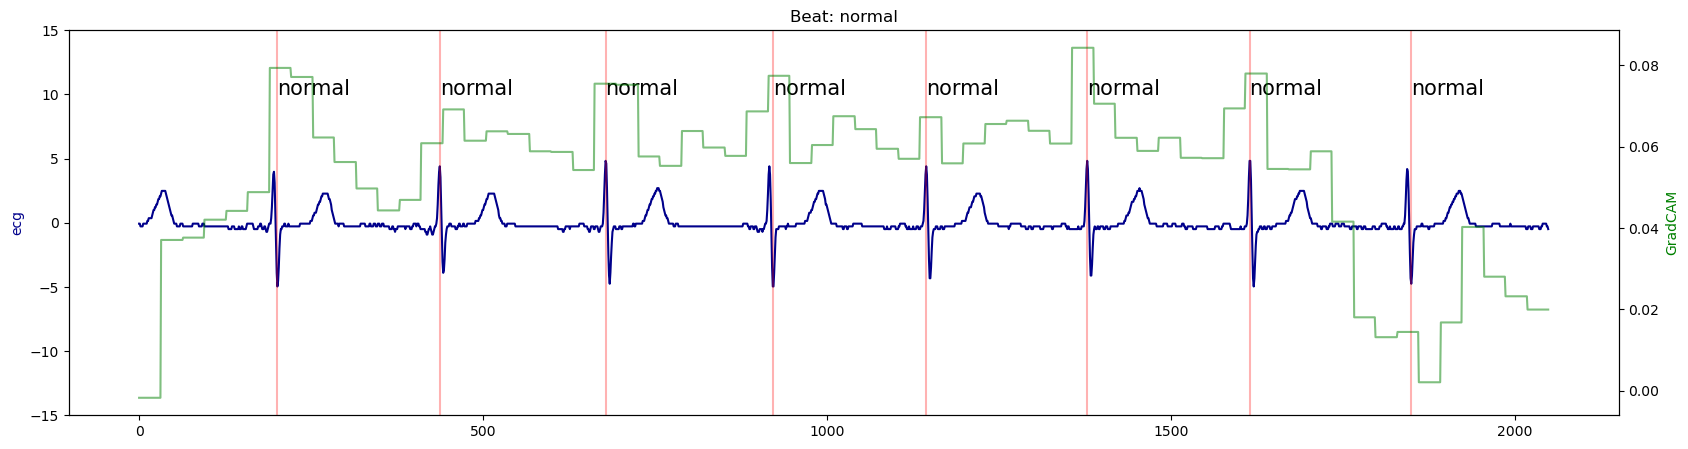

<Figure size 2000x500 with 0 Axes>

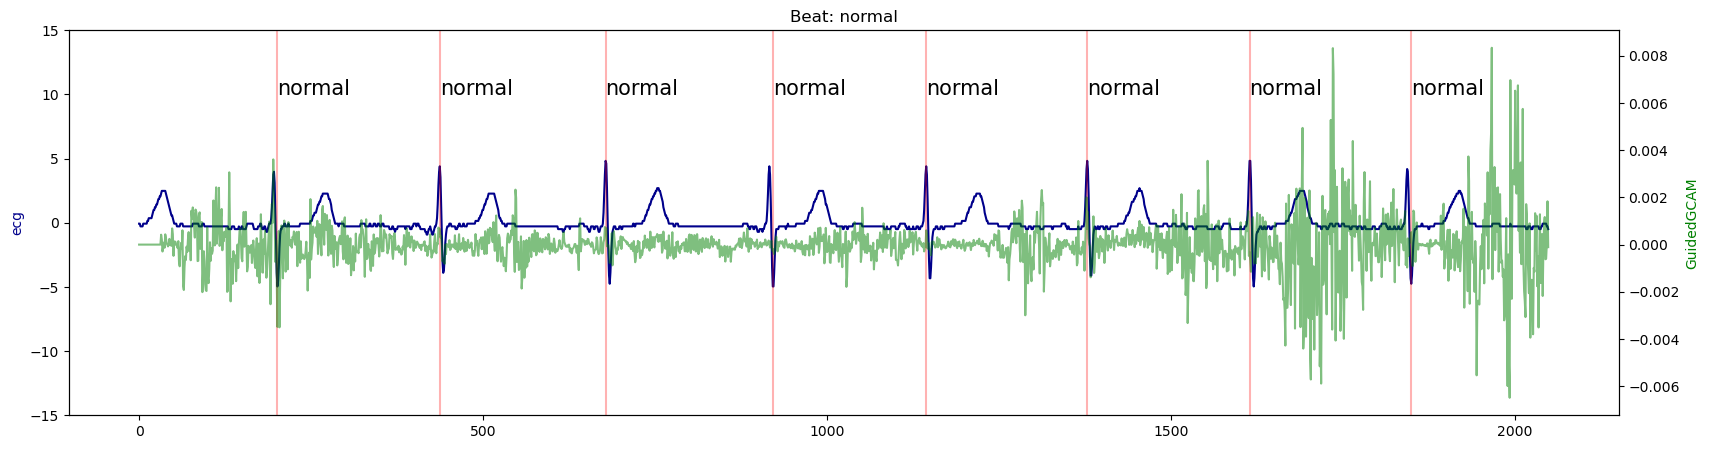

In [89]:
sample_X = X_test_ds[IDX]

sample_true_label = one_hot_to_true_label[y_test_ds[IDX]]

sample_raw_label = y_test_btype_raw_ds[IDX]
flat_raw_label = flatten_raw_label(sample_raw_label)

for attr_method in list(attr_dict.keys()):
    attr_x = attr_dict[attr_method]

    plt.figure(figsize=(20, 5))

    fig, ax1 = plt.subplots(figsize=(20, 5))
    plt.ylim(-15, 15)

    plt.title(f"Beat: {sample_true_label}")

    ax2 = ax1.twinx()
    ax1.plot(sample_X.squeeze(), c='darkblue')
    for i, lbl in flat_raw_label.items():
        ax1.axvline(i, alpha=0.3, color='r')
        ax1.text(i, 10, lbl, fontsize=15)
    ax2.plot(to_np(attr_x.squeeze()), c='green', alpha=0.5)

    ax1.set_ylabel('ecg', color='darkblue')
    ax2.set_ylabel(attr_method, color='green')

    plt.show()
    plt.close()

tensor([[[[0.0017, 0.0371, 0.0376, 0.0421, 0.0442, 0.0488, 0.0794, 0.0772,
           0.0623, 0.0562, 0.0497, 0.0443, 0.0469, 0.0609, 0.0692, 0.0615,
           0.0638, 0.0631, 0.0589, 0.0587, 0.0543, 0.0755, 0.0752, 0.0576,
           0.0553, 0.0639, 0.0598, 0.0578, 0.0687, 0.0774, 0.0560, 0.0604,
           0.0675, 0.0643, 0.0595, 0.0570, 0.0673, 0.0559, 0.0608, 0.0656,
           0.0664, 0.0639, 0.0608, 0.0843, 0.0706, 0.0622, 0.0590, 0.0622,
           0.0573, 0.0572, 0.0694, 0.0780, 0.0545, 0.0544, 0.0589, 0.0416,
           0.0180, 0.0132, 0.0144, 0.0021, 0.0168, 0.0403, 0.0280, 0.0232,
           0.0200]]]], device='cuda:6', grad_fn=<AbsBackward0>)